It has been observed in prior work that tasks sharing some underlying structure will exhibit overlapping neural activity. For instance, Yang et. al. (2019) trained RNNs on several cognitive tasks and observed clustering in the neural activity space: some clusters specialized to particular tasks, while others were shared between tasks. In theory, it is also possible to observe a completely distributed representation (i.e. no modular clusters). While Yang focused on sensory tasks, we aim to study tasks involving abstract relations: transitive inference, subset inclusion, and divisibility. These tasks are likely to have some common underlying structure, as both represent transitive relations. We will compare the neural geometry of the same model trained on one of these tasks at a time to that trained on both (using interleaving).

Finally, we will train an RNN on a secondary task requiring the representations learned in the transitive inference task. While we have not finalized this task, its purpose is to generate interesting dynamics. One example may be: At each time step, a new item (from the items learned during the TI task) will be presented to the RNN. Its task will be to output the items it has seen so far in the correct order at each time step. Another idea is to show the RNN two inputs at each time step and to morph one of the inputs until the relationship between the inputs is flipped (for example, if the first input is ‘greater’, then ‘shrink’ it until the second input is ‘greater’, where the notion of ‘greater than’ is relative to the task). The RNN’s task would be to return 0 while the original relation holds, and 1 once it no longer holds.

Questions we hope to answer: How will the neural representation of a given task change when more than one task is learned simultaneously? In the latter case, will we find that the activations shared between the two tasks are also present in some form when only one task is learned at a time? That is—does a neural network organize its activity differently when related tasks must be learned together? We will use RDM analysis and dimensionality reduction techniques to look for specialized clusters in neural activity space. We will then compare our networks using RSA/RDA, as well as dynamics-based methods such as DSA and fixed/slow point analysis.

In [ ]:
# Transitive Inference: (i.e. index 0 is greater than index 1 = "A > B")
# Example stimulus: [[1, 0, 0],[0, 1, 0]]
# Example output: 0

# Subset Inclusion: (i.e. index 0 is greater than index 1 = "A \contains B")
# Example stimulus: [[1, 1, 1],[0, 1, 0]]
# Example output: 0 = "A \contains B"

# Divisibility:
# Example stimulus: [6,3]
# Example output: 0 = "A is divisble by B"

In [ ]:
# @title Imports

# General
import numpy as np
import pandas as pd
from scipy.stats import zscore
import matplotlib as mpl
from matplotlib import pyplot as plt
import random
from statistics import mean
import math

# Deep learning
import torch
from torch import nn, optim

# # Response visualizations
# !pip install umap-learn
# import umap
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(12)
torch.manual_seed(12)

In [ ]:
# @title Helper Functions


def get_hidden_activity(net, stimuli, layer_labels):
  """Retrieve internal representations of network

  Args:
    net (nn.Module): deep network
    stimuli (torch.Tensor): input to the network
    layer_labels (list): list of strings with labels of each layer for which
      to return its internal representations

  Returns:
    dict: internal representations at each layer of the network, in
      numpy arrays. The keys of this dict are the strings in layer_labels.

  """

  hidden_activity = {}

  # Attach hooks to each layer of the network to store hidden
  # representations in hidden_activity
  def hook(module, input, output):
    module_label = list(net._modules.keys())[np.argwhere([module == m for m in net._modules.values()])[0, 0]]
    if module_label in layer_labels:
      hidden_activity[module_label] = output.view(stimuli.shape[0], -1).cpu().detach().numpy()
  hooks = [layer.register_forward_hook(hook) for layer in net.children()]

  # Run stimuli through the network
  pred = net.predict(stimuli)

  # Remove the hooks
  [h.remove() for h in hooks]

  return hidden_activity

In [ ]:
# @title Task design: Part I

def make_stimulus_dict(input_length, task='ti'):
    stimulus_order_dict = []

    if task == 'ti':
      for index in range(input_length):
        stimulus_key = [0]*input_length
        stimulus_key[index] = 1
        stimulus_order_dict.append(stimulus_key)
      random.shuffle(stimulus_order_dict)

    # elif task == "si":
    #   for index in range(input_length):
    #     stimulus_key = [0]*input_length


    return stimulus_order_dict

def get_batch(batch_size, task, stimulus_dict=None, input_length=3, mode='train'):

  # Helpers
  def get_binary_vec(input_length):
    return [random.randint(0, 1) for _ in range(input_length)]

  def make_stimulus(input_length, task='ti'):
    if task == 'ti':
      if mode == 'test':
        dict_indices = [0,0]
        while abs(dict_indices[0] - dict_indices[1]) < 2:
          dict_indices = random.sample(range(input_length), 2)
          random.shuffle(dict_indices)
      elif mode == 'train':
        temp_idx = random.sample(range(input_length-1), 1)
        dict_indices = [temp_idx[0], temp_idx[0]+1]
        random.shuffle(dict_indices)

      stimulus = [stimulus_dict[i] for i in dict_indices]

      if dict_indices[0] < dict_indices[1]: # If the first item is greater, it appears earlier in the list
        target = 0
      else:
        target = 1

    elif task == 'si':
      stimulus = [0,0]
      while stimulus[0] == stimulus[1]:
        stimulus = [get_binary_vec(input_length), get_binary_vec(input_length)]

      if stimulus[0] > stimulus[1]: # If first binary number is greater, it is the superset
        target = 0
      else:
        target = 1

    # elif task == "div":
    #   stimulus = [random.sample(range(0, 100, 2),1)[0], random.sample(range(0, 100, 2),1)[0]]
    #   if stimulus[0] % stimulus[1] == 0:
    #     target = 0
    #   else:
    #     target = 1

    return stimulus, target

  stimuli = []
  labels = []
  for _ in range(batch_size):
    stimulus, target = make_stimulus(input_length, task)
    stimuli.append(stimulus)
    labels.append(target)

  stimuli = torch.tensor(stimuli).float()
  labels = torch.tensor(labels).float()

  if torch.cuda.is_available():
    stimuli = stimuli.to('cuda')
    labels = labels.to('cuda')

  return stimuli, labels

In [ ]:
input_length = 5
stimulus_dict = make_stimulus_dict(input_length)
print(stimulus_dict,'\n')
get_batch(10, 'ti', stimulus_dict, input_length, mode='test')

[[0, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 1, 0], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0]] 



(tensor([[[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]],
 
         [[0., 1., 0., 0., 0.],
          [1., 0., 0., 0., 0.]],
 
         [[0., 0., 1., 0., 0.],
          [0., 1., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1.]],
 
         [[0., 0., 0., 1., 0.],
          [0., 0., 1., 0., 0.]],
 
         [[0., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 1., 0.],
          [0., 1., 0., 0., 0.]],
 
         [[0., 1., 0., 0., 0.],
          [0., 0., 1., 0., 0.]],
 
         [[0., 0., 1., 0., 0.],
          [0., 1., 0., 0., 0.]]]),
 tensor([1., 0., 1., 0., 1., 0., 0., 1., 0., 1.]))

In [ ]:
# @title Architecture: Feedforward

# Inputs: list of two vectors
# Outputs: scalar (0/1)

# Helpers
def get_resp_layer_labels(net):
  layer_names = list(net._modules.keys())
  return layer_names

def get_resp_layer_inputs(task='ti', stimulus_dict=None):
  if task == 'ti':
    return stimulus_dict

class Feedforward(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(Feedforward, self).__init__()
    self.fc1 = nn.Linear(input_dim*2, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()
    # self.relu = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.fc1(x)
    # x = self.relu(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    return x.squeeze()

  def predict(self, x):
    with torch.no_grad():
      return torch.relu(self.forward(x))

  def evaluate(self, dataset_size, task='ti', stimulus_dict=None):
    with torch.no_grad():
      test_stimuli, test_labels = get_batch(params_dict['dataset_size'], task, stimulus_dict, mode='test')
      loss_fn = nn.BCELoss()

      track_loss = []
      for i in range(params_dict['dataset_size']//params_dict['batch_size']):
        out = self.forward(test_stimuli)
        loss = loss_fn(out, test_labels)
        track_loss.append(loss.item())

      return mean(track_loss)

def train_loop(net, response_dict=False, **params_dict):

  # # Initialize response dictionary and inputs
  # if response_dict:
  #   resp_layer_labels = get_resp_layer_labels(net)
  #   resp_dict = {layer : [] for layer in resp_layer_labels}
  #   stimuli_for_hooks = get_resp_layer_inputs()
  # else: resp_dict = None

  criterion = nn.BCELoss()
  optimizer = optim.SGD(net.parameters(), lr=params_dict['learning_rate'], momentum=params_dict['momentum'])

  track_loss = []

  for i in range(params_dict.get('n_epochs')):
    for j in range(params_dict['dataset_size']//params_dict['batch_size']):
      stimuli, labels = get_batch(params_dict['batch_size'], params_dict['task'], stimulus_dict, params_dict['input_length'])

      out = net.forward(stimuli)
      loss = criterion(out, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      track_loss.append(loss.item())
      if i % 100 == 0:
        print(f'epoch {i + 1} | loss on last batch: {loss.item(): 3e}')

  # FIX LATER
      # if response_dict:
      #   if (i + 1) % (n_epochs // 25) == 0:
      #   for layer in resp_layer_labels:
      #     resp_dict[layer].append(get_hidden_activity(net, stimuli_for_hooks[layer], [layer])[layer])

  return track_loss, response_dict

In [ ]:
params_dict = {
    'batch_size': 10,
    'n_epochs': 200,
    'dataset_size': 1000,
    'learning_rate': 0.0005,
    'momentum': .99,
    'task': 'ti',
    'input_length': 10
}

In [ ]:
stimulus_dict = make_stimulus_dict(params_dict['input_length'])

In [ ]:
net = Feedforward(input_dim=params_dict['input_length'], hidden_dim=10, output_dim=1)
if torch.cuda.is_available():
  net.cuda()

track_loss, resp_dict = train_loop(net, response_dict=True, **params_dict)

epoch 1 | loss on last batch:  7.278697e-01
epoch 1 | loss on last batch:  6.982560e-01
epoch 1 | loss on last batch:  7.018268e-01
epoch 1 | loss on last batch:  6.737809e-01
epoch 1 | loss on last batch:  7.505219e-01
epoch 1 | loss on last batch:  6.953648e-01
epoch 1 | loss on last batch:  6.899623e-01
epoch 1 | loss on last batch:  6.884109e-01
epoch 1 | loss on last batch:  7.238373e-01
epoch 1 | loss on last batch:  7.110880e-01
epoch 1 | loss on last batch:  6.855608e-01
epoch 1 | loss on last batch:  6.707398e-01
epoch 1 | loss on last batch:  6.995573e-01
epoch 1 | loss on last batch:  7.373997e-01
epoch 1 | loss on last batch:  6.743290e-01
epoch 1 | loss on last batch:  6.821994e-01
epoch 1 | loss on last batch:  6.722899e-01
epoch 1 | loss on last batch:  6.910343e-01
epoch 1 | loss on last batch:  6.583254e-01
epoch 1 | loss on last batch:  7.197160e-01
epoch 1 | loss on last batch:  6.935943e-01
epoch 1 | loss on last batch:  7.304868e-01
epoch 1 | loss on last batch:  7

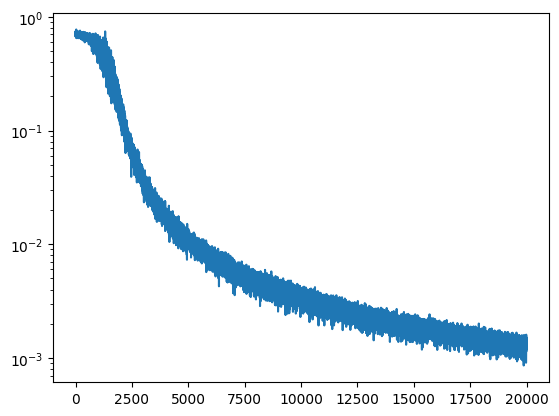

In [ ]:
# Input size = 10
plt.yscale('log')
plt.plot(track_loss)
plt.show()

In [ ]:
#@title Save the model weights
torch.save(net.state_dict(), '/content/ff_10_weights')
!cp '/content/ff_10_weights' '/content/drive/MyDrive/NMA_NeuroAI/ff_10_weights'

In [ ]:
#@title Load the saved Feedforward model.
!cp '/content/drive/MyDrive/NMA_NeuroAI/ff_10_weights' '/content/ff_10_weights'

model = Feedforward(input_dim=params_dict['input_length'], hidden_dim=10, output_dim=1)
model.load_state_dict(torch.load('/content/ff_10_weights'))

<All keys matched successfully>

# Second task

In [ ]:
params_dict = {
    'batch_size': 10,
    'n_epochs': 200,
    'dataset_size': 1000,
    'learning_rate': 0.0005,
    'momentum': .99,
    'task': 'ti',
    'input_length': 10
}

In [ ]:
stimulus_dict = make_stimulus_dict(params_dict['input_length'])

In [ ]:
net = Feedforward(input_dim=params_dict['input_length'], hidden_dim=10, output_dim=1)
if torch.cuda.is_available():
  net.cuda()

track_loss, resp_dict = train_loop(net, response_dict=True, **params_dict)

epoch 1 | loss on last batch:  7.278697e-01
epoch 1 | loss on last batch:  6.982560e-01
epoch 1 | loss on last batch:  7.018268e-01
epoch 1 | loss on last batch:  6.737809e-01
epoch 1 | loss on last batch:  7.505219e-01
epoch 1 | loss on last batch:  6.953648e-01
epoch 1 | loss on last batch:  6.899623e-01
epoch 1 | loss on last batch:  6.884109e-01
epoch 1 | loss on last batch:  7.238373e-01
epoch 1 | loss on last batch:  7.110880e-01
epoch 1 | loss on last batch:  6.855608e-01
epoch 1 | loss on last batch:  6.707398e-01
epoch 1 | loss on last batch:  6.995573e-01
epoch 1 | loss on last batch:  7.373997e-01
epoch 1 | loss on last batch:  6.743290e-01
epoch 1 | loss on last batch:  6.821994e-01
epoch 1 | loss on last batch:  6.722899e-01
epoch 1 | loss on last batch:  6.910343e-01
epoch 1 | loss on last batch:  6.583254e-01
epoch 1 | loss on last batch:  7.197160e-01
epoch 1 | loss on last batch:  6.935943e-01
epoch 1 | loss on last batch:  7.304868e-01
epoch 1 | loss on last batch:  7

# Collapse

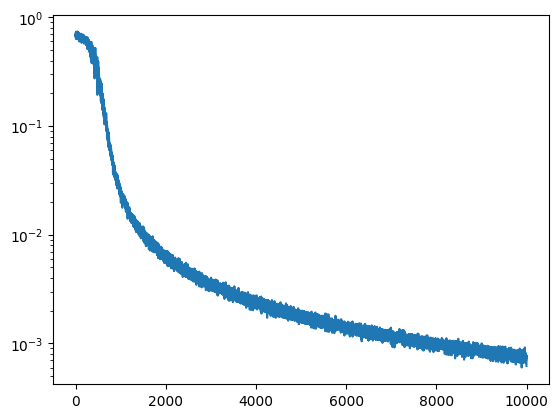

In [ ]:
# Input size = 5
plt.yscale('log')
plt.plot(track_loss)
plt.show()

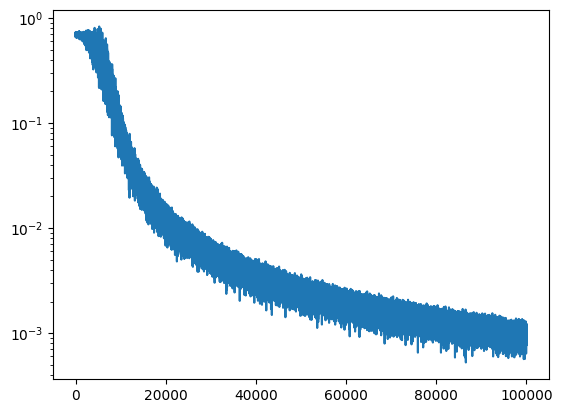

In [ ]:
# Input size = 25
plt.yscale('log')
plt.plot(track_loss)
plt.show()

In [ ]:
# Input length 5
net.evaluate(params_dict['dataset_size'], params_dict['task'], stimulus_dict)

5.754082508246938e-07

In [ ]:
# Input length 25
net.evaluate(params_dict['dataset_size'], params_dict['task'], stimulus_dict)

8.30100432835934e-08

In [ ]:
# From Sam's code (make sure to properly credit if we use this)

import itertools

def get_test_data(n):
    """Generate test data for relational tasks.
    """
    test_x = np.zeros((n, n, 2*n))
    for i, j in itertools.product(range(n), range(n)):
        test_x[i,j,i] = 1
        test_x[i,j,n+j] = 1
    test_x = torch.from_numpy(test_x).float()
    test_x = test_x/torch.sqrt(torch.tensor(2))
    return test_x

def get_transitive_data(n):
    """Generate training data for TI task.
    """
    test_x = get_test_data(n)
    x = test_x[tuple(zip(*([(i, i+1) for i in range(n-1)] + [(i+1, i) for i in range(n-1)])))]
    y = torch.tensor([1.]*(n-1)+[-1.]*(n-1))
    return x, y

get_transitive_data(5)

(tensor([[0.7071, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7071, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.7071, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7071, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.7071, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7071,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.7071, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.7071],
         [0.0000, 0.7071, 0.0000, 0.0000, 0.0000, 0.7071, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.7071, 0.0000, 0.0000, 0.0000, 0.7071, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.7071, 0.0000, 0.0000, 0.0000, 0.7071, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.7071, 0.0000, 0.0000, 0.0000, 0.7071,
          0.0000]]),
 tensor([ 1.,  1.,  1.,  1., -1., -1., -1., -1.]))

In [ ]:
# Math question:
# Figure out the best input size vs batch size

In [ ]:
# @title Architecture: RNN

# Inputs: list of integers x number of time steps
# Outputs: list of integers x number of time steps

# OR

# Inputs: list of two vectors x number of time steps
# Outputs: scalar (0/1) x number of time steps

